# drive 마운트, seed 고정

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import os
import pandas as pd
import numpy as np
import random

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import xgboost as xgb
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.cluster import MiniBatchKMeans


In [16]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

# 데이터 로드 및 전처리

In [17]:
train_data  = pd.read_csv('/content/drive/MyDrive/날씨 콘테스트/fog_train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/날씨 콘테스트/fog_test.csv')

# 열 이름 변경
train_data.columns = train_data.columns.str.replace('fog_train.', '')
test_data.columns = test_data.columns.str.replace('fog_test.', '')

# 'Unnamed: 0' 열 제거
train_data.drop(columns=['Unnamed: 0'], inplace=True)
test_data.drop(columns=['Unnamed: 0'], inplace=True)

# 테스트 데이터에서 class 열 제거, 목표변수가 test데이터 열에 포함되면 안되기 때문
test_data = test_data.drop(columns=['class'], errors='ignore')

# 필요없는 특성 제거
train_data = train_data.drop(['year','re'], axis=1)
test_data = test_data.drop(['year','re'], axis=1)

In [18]:
# 안개 발생 모델은 5개지역으로 나뉨으로, 20개 지점을 5개로 축약
# ex) AA -> A, BA ->B로 바꾼다
# 'stn_id' 열에서 첫 글자만 추출하여 축약
train_data['stn_id'] = train_data['stn_id'].str.slice(0, 1)
test_data['stn_id'] = test_data['stn_id'].str.slice(0, 1)

In [19]:
# 결측값 처리 (-99, -99.9를 NaN으로 대체)
train_data.replace([-99, -99.9], np.nan, inplace=True)
test_data.replace([-99, -99.9], np.nan, inplace=True)

# 결측치 있는 column 분리
cols_with_na = train_data.columns[train_data.isna().any()]
cols_no_na = train_data.columns[~train_data.columns.isin(cols_with_na)]

# vis1의 결측값을 먼저 대체
vis1_imputer = IterativeImputer(random_state=42)
train_data[['vis1']] = vis1_imputer.fit_transform(train_data[['vis1']])

# vis1 값을 바탕으로 class 결측값 대체
def fill_class(row):
    if pd.isna(row['class']):
        if row['vis1'] < 200:
            return 1
        elif 200 <= row['vis1'] < 500:
            return 2
        elif 500 <= row['vis1'] < 1000:
            return 3
        else:
            return 4
    else:
        return row['class']

train_data['class'] = train_data.apply(fill_class, axis=1)

# vis1, class 열을 제외한 나머지 수치형 변수들에 대해 Iterative Imputer 사용
# 결측치 보간을 2단계로 나눈 이유는, test에는 목표변수인 class, 시정구간을 알 수 있는 변수 인 vis1이 없기 때문
# iteratvie 객체 초기화
cols_with_na_no_class = cols_with_na.drop(['vis1','class'])
imputer = IterativeImputer(random_state=42)
train_na = pd.DataFrame(imputer.fit_transform(train_data[cols_with_na_no_class]), columns=cols_with_na_no_class)
test_na = pd.DataFrame(imputer.transform(test_data[cols_with_na_no_class]), columns=cols_with_na_no_class)

# 결측치가 없는 열을 추가
train_imputed = pd.concat([train_na, train_data.drop(columns=cols_with_na_no_class)], axis=1)
test_imputed = pd.concat([test_na, test_data.drop(columns=cols_with_na_no_class)], axis=1)

# 파생 변수 추가
train_imputed['Temp_Diff'] = train_imputed['ta'] - train_imputed['ts']
test_imputed['Temp_Diff'] = test_imputed['ta'] - test_imputed['ts']

train_imputed['Humidity_Wind_Interaction'] = train_imputed['hm'] / (train_imputed['ws10_ms'] + 1)
test_imputed['Humidity_Wind_Interaction'] = test_imputed['hm'] / (test_imputed['ws10_ms'] + 1)

train_imputed['Fog_Likelihood_Index'] = (train_imputed['Temp_Diff'] * train_imputed['hm']) / (train_imputed['ws10_ms'] + 1)
test_imputed['Fog_Likelihood_Index'] = (test_imputed['Temp_Diff'] * test_imputed['hm']) / (test_imputed['ws10_ms'] + 1)

train_imputed['Dew_Point'] = 243.04 * (np.log(train_imputed['hm']/100) + ((17.625*train_imputed['ta'])/(243.04+train_imputed['ta']))) / (17.625 - np.log(train_imputed['hm']/100) - ((17.625*train_imputed['ta'])/(243.04+train_imputed['ta'])))
test_imputed['Dew_Point'] = 243.04 * (np.log(test_imputed['hm']/100) + ((17.625*test_imputed['ta'])/(243.04+test_imputed['ta']))) / (17.625 - np.log(test_imputed['hm']/100) - ((17.625*test_imputed['ta'])/(243.04+test_imputed['ta'])))

# 필요없는 feature 제거
train_imputed = train_imputed.drop(['ts'], axis=1)
test_imputed = test_imputed.drop(['ts'], axis=1)


In [20]:
# 범주형 변수 인코딩
cat_cols = train_imputed.select_dtypes(include=['object']).columns

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
train_cat_encoded = pd.DataFrame(encoder.fit_transform(train_imputed[cat_cols]))
test_cat_encoded = pd.DataFrame(encoder.transform(test_imputed[cat_cols]))

train_cat_encoded.columns = encoder.get_feature_names_out(cat_cols)
test_cat_encoded.columns = encoder.get_feature_names_out(cat_cols)

# 인코딩된 범주형 변수와 수치형 변수를 다시 합침
train_imputed = pd.concat([train_imputed.drop(columns=cat_cols), train_cat_encoded], axis=1)
test_imputed = pd.concat([test_imputed.drop(columns=cat_cols), test_cat_encoded], axis=1)


In [21]:
# 처리과정 후 생기는 결측치는 그냥 제거
train_imputed = train_imputed.dropna()
test_imputed = test_imputed.dropna()

#XGBOOST

In [22]:
# 특징과 라벨 분리
X = train_imputed.drop(['class','vis1'], axis=1)
y = train_imputed['class']

# 오버샘플링 적용 전 클래스 비율 확인
print("Original class distribution:")
print(y.value_counts(normalize=True))

# 각 클래스의 샘플 개수 확인
class_counts = y.value_counts()

# 샘플링 전략 설정
sampling_strategy = {
    1: int(class_counts[1] * 20.0),  # 클래스 1의 목표 샘플 수
    2: int(class_counts[2] * 20.0),  # 클래스 2의 목표 샘플 수
    3: int(class_counts[3] * 20.0),  # 클래스 3의 목표 샘플 수
    4: class_counts[4]  # 클래스 4는 원래 개수 유지
}

# 오버샘플링 적용
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# 오버샘플링 적용 후 클래스 비율 확인
print("Class distribution after SMOTE:")
print(pd.Series(y_res).value_counts(normalize=True))

# 학습 데이터와 검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

Original class distribution:
class
4.0    0.989820
3.0    0.003859
2.0    0.003830
1.0    0.002492
Name: proportion, dtype: float64
Class distribution after SMOTE:
class
4.0    0.829392
3.0    0.064667
2.0    0.064178
1.0    0.041763
Name: proportion, dtype: float64


In [23]:
# 클래스 라벨을 0부터 시작하도록 변환
y_train -= 1
y_val -= 1

# 클래스 가중치 계산
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# 가중치 부여
weights = np.array([class_weights[label] for label in y_train])

# DMatrix 생성
dtrain = xgb.DMatrix(X_train, label=y_train, weight=weights)
dval = xgb.DMatrix(X_val, label=y_val)

# XGBoost 모델 학습
param = {
    'objective': 'multi:softmax',
    'num_class': 4,
    'eval_metric': 'mlogloss',
    'eta': 0.3,
    'max_depth': 6,
    'seed': 42
}

num_round = 1000
evallist = [(dval, 'eval'), (dtrain, 'train')]
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)

# 예측
y_pred = bst.predict(dval)

# 클래스 라벨을 원래대로 복원
y_val += 1
y_pred += 1

# 혼동 행렬 계산
cm = confusion_matrix(y_val, y_pred, labels=[1, 2, 3, 4])

# 혼동 행렬 출력
print("Confusion Matrix:")
print(cm)

# 다중 CSI 계산
H = cm[0, 0] + cm[1, 1] + cm[2, 2]  # H11, H22, H33
F = (cm[0, 1] + cm[0, 2] + cm[1, 0] +
     cm[1, 2] + cm[2, 0] + cm[2, 1] +
     cm[3, 0] + cm[3, 1] + cm[3, 2]) # F12, F13, F21, F23, F31, F32, F41, F42, F43
M = cm[0, 3] + cm[1, 3] + cm[2, 3]  # M14, M24, M34

CSI = H / (H + F + M)
print(f"CSI: {CSI:.2f}")

[0]	eval-mlogloss:1.06886	train-mlogloss:1.22530
[1]	eval-mlogloss:0.89644	train-mlogloss:1.12790
[2]	eval-mlogloss:0.78624	train-mlogloss:1.06079
[3]	eval-mlogloss:0.70938	train-mlogloss:1.01292
[4]	eval-mlogloss:0.65419	train-mlogloss:0.97622
[5]	eval-mlogloss:0.61409	train-mlogloss:0.94705
[6]	eval-mlogloss:0.58467	train-mlogloss:0.92440
[7]	eval-mlogloss:0.56108	train-mlogloss:0.90436
[8]	eval-mlogloss:0.54302	train-mlogloss:0.88902
[9]	eval-mlogloss:0.52856	train-mlogloss:0.87690
[10]	eval-mlogloss:0.51590	train-mlogloss:0.86457
[11]	eval-mlogloss:0.50626	train-mlogloss:0.85472
[12]	eval-mlogloss:0.49593	train-mlogloss:0.84509
[13]	eval-mlogloss:0.48917	train-mlogloss:0.83680
[14]	eval-mlogloss:0.48061	train-mlogloss:0.82899
[15]	eval-mlogloss:0.47066	train-mlogloss:0.81834
[16]	eval-mlogloss:0.46302	train-mlogloss:0.81008
[17]	eval-mlogloss:0.45501	train-mlogloss:0.80265
[18]	eval-mlogloss:0.44790	train-mlogloss:0.79466
[19]	eval-mlogloss:0.44044	train-mlogloss:0.78872
[20]	eval-

Feature Importance:
                      Feature  Importance
0                    ws10_deg     30169.0
11       Fog_Likelihood_Index     23030.0
9                   Temp_Diff     20488.0
3                          hm     19376.0
6                         day     17338.0
8                      minute     15097.0
2                          ta     14672.0
7                        time     13651.0
12                  Dew_Point     13295.0
10  Humidity_Wind_Interaction     11959.0
1                     ws10_ms     11778.0
4                       sun10      9448.0
5                       month      9443.0
16                   stn_id_D      4102.0
13                   stn_id_A      3884.0
14                   stn_id_B      3813.0
17                   stn_id_E      2484.0
15                   stn_id_C      2218.0


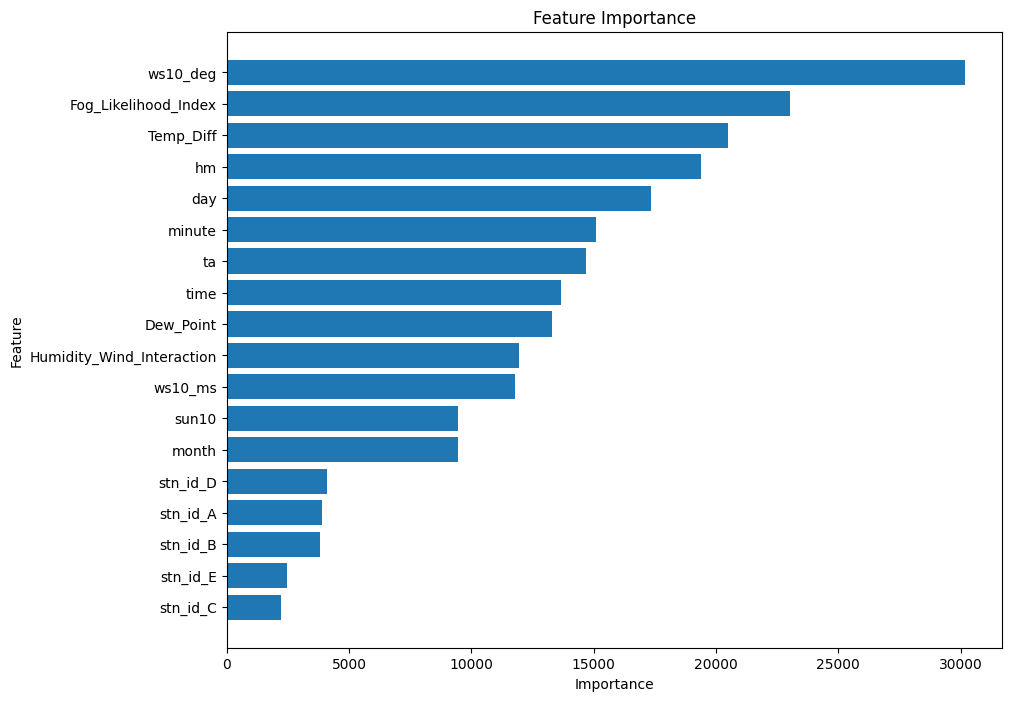

In [24]:
# Feature importance 구하기
importance = bst.get_score(importance_type='weight')
importance_df = pd.DataFrame(importance.items(), columns=['Feature', 'Importance'])

# 중요도 내림차순으로 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# feature importance 출력
print("Feature Importance:")
print(importance_df)

# 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [25]:
# 테스트 데이터 예측
dtest = xgb.DMatrix(test_imputed)
y_test_pred = bst.predict(dtest)

# 예측 결과를 원래 클래스 라벨로 변환
y_test_pred = y_test_pred.astype(int) + 1

# 제출하기 위해 test데이터 다시 불러옴
sub_test_data = pd.read_csv('/content/drive/MyDrive/날씨 콘테스트/fog_test.csv')
sub_test_data = sub_test_data.drop(columns=['fog_test.class'], errors='ignore')

# 예측 결과를 데이터프레임으로 저장
sub_test_data['fog_test.class'] = y_test_pred

# 예측 결과 저장
sub_test_data.to_csv('240184.csv', index=False)
sub_test_data["fog_test.class"].value_counts()

fog_test.class
4    257364
2      2358
3      2199
1       879
Name: count, dtype: int64

In [26]:
# 파일 다운로드
from google.colab import files
files.download('240184.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>